# What TOC rules have had the biggest impact?

We would like to evaluate which Transit Oriented Communities rules have had the biggest impact,
and which transit lines have seen the most development.

We will proceed by reconstructing a TOC map,
and try to assign developments to specific transit lines.

In [1]:
import datetime
import functools
import contextily
import intake
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import toc
import boto3

In [2]:
catalog = intake.open_catalog("../catalogs/*.yml")
city_boundary = catalog.city_boundary.read()

s3 = boto3.client('s3')
bucket_name = 'city-planning-entitlements'

We will err on the side of finding ineligible lines, since headways and stops can change.
In order to do that, we will have a headway cutoff greater than the TOC cutoff of 15 minutes,
and buffer the tiers an additional 20%.

In [3]:
cutoff = 18.0
cushion = 1.2

## TOC Tiers from bus service

Let's read some GTFS feeds to get representative weekday peak frequencies for
Metro Bus, Santa Monica Big Blue Bus, and Culver City Bus:

In [4]:
# Current Metro GTFS
# METRO_BUS_GTFS_URL = "https://gitlab.com/LACMTA/gtfs_bus/-/raw/master/gtfs_bus.zip?inline=false"

# Metro GTFS from December 2017
#METRO_BUS_GTFS_URL = "https://gitlab.com/LACMTA/gtfs_bus/-/raw/aef844c79c31c40ef751a3472b3882406307b05a/gtfs_bus.zip?inline=false"
METRO_BUS_GTFS_URL = f"s3://{bucket_name}/data/source/LA_Metro_GTFS/gtfs_bus.zip"

# Current Big Blue Bus GTFS
#BBB_GTFS_URL = "http://gtfs.bigbluebus.com/current.zip"
BBB_GTFS_URL = f"s3://{bucket_name}/data/source/Big_Blue_Bus_GTFS/current.zip"

# Current 
#CC_GTFS_URL = "https://www.culvercity.org/home/showdocument?id=18585"
CC_GTFS_URL = f"s3://{bucket_name}/data/source/Culver_City_GTFS/culvercitybus-Jan2020.zip"

# A cutoff headway, in minutes, for determining TOC eligible bus lines.
# This is highter than the TOC value of 15 minutes, but we want to err
# on the side of catching edge cases, or cases where the frequency has
# changed since the TOC entitlement.

test_date = datetime.date(2018, 2, 8)

# Load TOC lines for Metro, Big Blue Bus, and Culver City Bus
metro_bus_toc_lines = toc.toc_bus_lines(
    METRO_BUS_GTFS_URL,
    cutoff=cutoff,
    test_date=test_date,
)
bbb_toc_lines = toc.toc_bus_lines(BBB_GTFS_URL, cutoff=cutoff)
cc_toc_lines = toc.toc_bus_lines(CC_GTFS_URL, cutoff=cutoff)

# Combine into one.
toc_bus_lines = pd.concat(
    [metro_bus_toc_lines, bbb_toc_lines, cc_toc_lines],
    axis=0,
    sort=False
)

We now find where the TOC eligible bus lines intersect,
and compute tier geometries for those intersections.

In [5]:
toc_bus_intersections = toc.bus_intersections(toc_bus_lines)
toc_bus_intersection_tiers = toc.compute_toc_tiers_from_bus_intersections(
    toc_bus_intersections,
    city_boundary,
    cushion=cushion,
)

In [6]:
toc_bus_intersection_tiers.head()

/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


,route_a,route_b,agency_a,route_name_a,agency_b,route_name_b,geometry,tier_1,tier_2,tier_3,tier_4
0,105-13108,10-13108,Metro - Los Angeles,105,Metro - Los Angeles,10/48,GEOMETRYCOLLECTION (POINT (-118.37652 34.08198...,"MULTIPOLYGON (((-118.26352 34.00386, -118.2635...","MULTIPOLYGON (((-118.27101 34.00385, -118.2710...",GEOMETRYCOLLECTION EMPTY,GEOMETRYCOLLECTION EMPTY
1,108-13108,10-13108,Metro - Los Angeles,108/358,Metro - Los Angeles,10/48,POINT (-118.27392 33.98921),"POLYGON ((-118.26347 33.98924, -118.26352 33.9...","POLYGON ((-118.27095 33.98922, -118.27097 33.9...",GEOMETRYCOLLECTION EMPTY,GEOMETRYCOLLECTION EMPTY
2,110-13108,10-13108,Metro - Los Angeles,110,Metro - Los Angeles,10/48,"MULTIPOINT (-118.27392 33.98243, -118.27176 33...","POLYGON ((-118.27288 33.99109, -118.27281 33.9...","POLYGON ((-118.27285 33.98473, -118.27263 33.9...",GEOMETRYCOLLECTION EMPTY,GEOMETRYCOLLECTION EMPTY
3,111-13108,10-13108,Metro - Los Angeles,111,Metro - Los Angeles,10/48,POINT (-118.26953 33.97472),"POLYGON ((-118.25909 33.97475, -118.25913 33.9...","POLYGON ((-118.26657 33.97473, -118.26658 33.9...",GEOMETRYCOLLECTION EMPTY,GEOMETRYCOLLECTION EMPTY
4,115-13108,10-13108,Metro - Los Angeles,115,Metro - Los Angeles,10/48,POINT (-118.26950 33.96012),"POLYGON ((-118.25905 33.96014, -118.25910 33.9...","POLYGON ((-118.26653 33.96013, -118.26654 33.9...",GEOMETRYCOLLECTION EMPTY,GEOMETRYCOLLECTION EMPTY


Let's create a plot of the TOC tiers due to bus intersections:

In [7]:
colors = ["#f1eef6", "#bdc9e1", "#74a9cf", "#0570b0"]
def plot_toc_tiers(gdf):
    fig, ax = plt.subplots(figsize=(16,16))
    WEB_MERCATOR = 3857
    city_boundary.to_crs(epsg=WEB_MERCATOR).plot(ax=ax, alpha=0.1, color="gray")
    for color, tier in zip(colors, range(1,5)):
        colname = f"tier_{tier}"
        t = gdf.set_geometry(colname)
        if not t[colname].is_empty.all():
            t.to_crs(epsg=WEB_MERCATOR).plot(ax=ax, color=color)
    contextily.add_basemap(ax, url=contextily.sources.ST_TONER_LITE)
    return fig

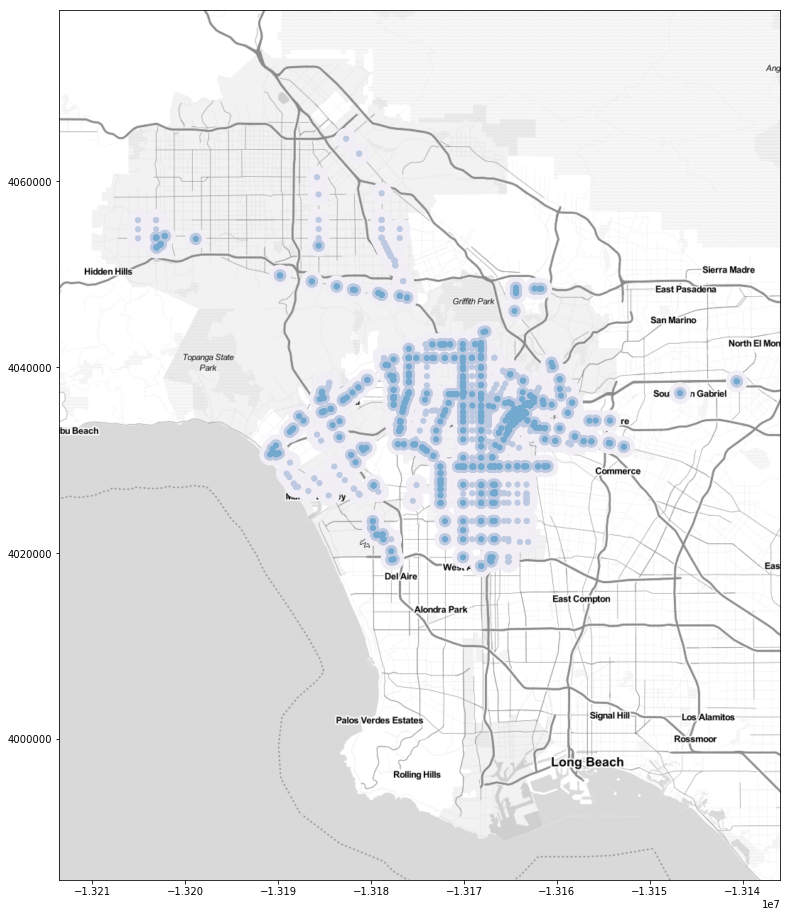

In [8]:
fig = plot_toc_tiers(toc_bus_intersection_tiers)
fig.show()

# TOC Tiers from Metrolink service

Metrolink stations (few though they may be) also generate TOC zones.
Here we create TOC tiers from the those:

In [9]:
metrolink_stations = catalog.metrolink_stations.read()
toc_metrolink_tiers = toc.compute_toc_tiers_from_metrolink_stations(
    metrolink_stations,
    city_boundary,
    cushion=cushion,
)

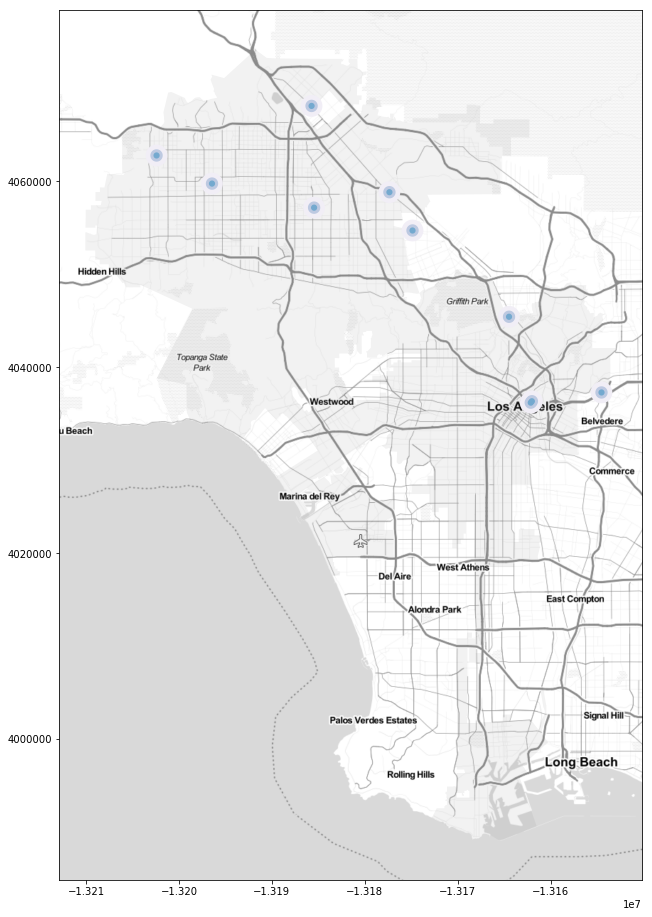

In [10]:
fig = plot_toc_tiers(toc_metrolink_tiers)
fig.show()

## TOC Tiers from Metro rail service

The most impactful TOC zones are from Metro rail stations.
Planned stations are included in TOC considerations, so we also
bring in data for the Crenshaw Line, the Purple Line, and the Regional Connector:

In [11]:
metro_rail_stations = catalog.metro_rail_stations.read()
# Read Crenshaw, Purple Line, and Regional Connector data from LA Times datadesk,
# who produced GeoJSON from Metro planning documents. I was not able to find
# the data elsewhere.
crenshaw = gpd.read_file(
    "https://raw.githubusercontent.com/datadesk/lametro-maps/master/planned-crenshaw-stops.geojson"
).rename(
    columns={"station": "STATION", "line": "LINE"}
).assign(LINENUM2=None, LINENUM=-1)
purple = gpd.read_file(
    "https://raw.githubusercontent.com/datadesk/lametro-maps/master/planned-purple-line-extension-stops.geojson"
).rename(
    columns={"name": "STATION"}
).assign(LINENUM2=None, LINENUM=805, LINE="Purple").drop(
    columns=["marker-color", "marker-size", "marker-symbol"]
)
regional_connector = gpd.read_file(
    "https://github.com/datadesk/lametro-maps/raw/master/planned-regional-connector-stops.json"
).assign(LINENUM2=None, LINENUM=801, LINE="Regional Connector")


all_metro_rail_stations = metro_rail_stations.append(crenshaw, sort = False).append(
                        purple, sort = False).append(regional_connector, sort = False)

all_metro_rail_stations.to_file(driver = 'GeoJSON', 
                                filename = '../gis/intermediate/active_planned_metro_rail_stations.geojson')

s3.upload_file('../gis/intermediate/active_planned_metro_rail_stations.geojson', 
               f'{bucket_name}', 'gis/intermediate/active_planned_metro_rail_stations.geojson')


toc_metro_rail_tiers = toc.compute_toc_tiers_from_metro_rail(
    metro_rail_stations.append(crenshaw, sort=False)
    .append(purple, sort=False)
    .append(regional_connector, sort=False),
    toc_bus_lines,
    city_boundary,
    cushion=cushion,
)

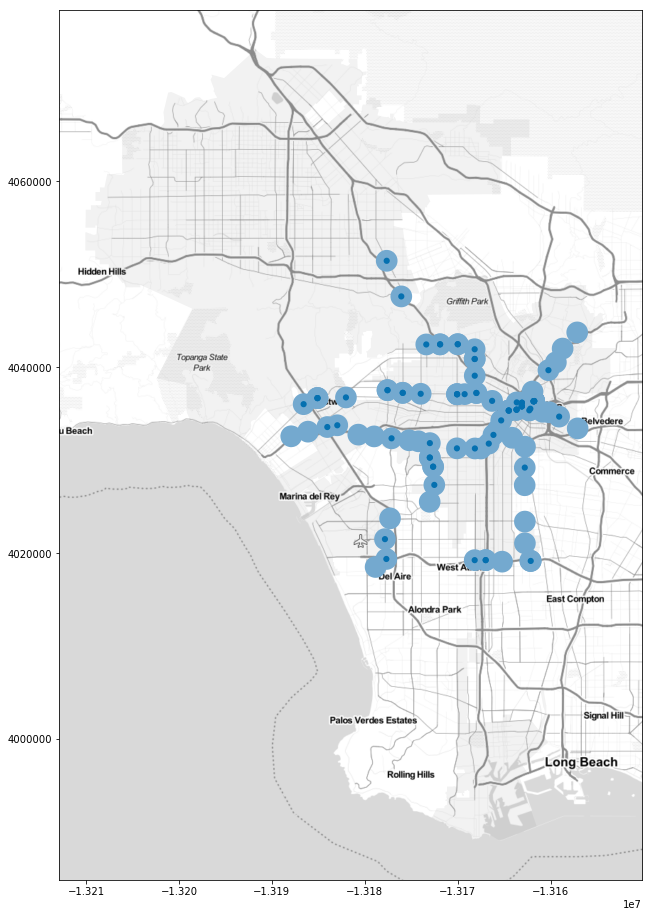

In [12]:
fig = plot_toc_tiers(toc_metro_rail_tiers)
fig.show()

## Full TOC tiers

All of the TOC tiers from above may be combined into a single TOC map:

In [13]:
# Rename and standardize columns before concatenating
# Bus
toc_bus_intersection_tiers.rename(columns = {"route_a": "line_id_a", 
                                             "route_b": "line_id_b",
                                             "route_name_a": "line_name_a", 
                                             "route_name_b": "line_name_b"}, inplace = True)

toc_bus_intersection_tiers["mode_a"] = "bus"
toc_bus_intersection_tiers["mode_b"] = "bus"

# Metrolink
toc_metrolink_tiers.rename(columns = {"name": "station_name", 
                                      "description": "line_name_a"}, inplace = True)

toc_metrolink_tiers["mode_a"] = "metrolink"
toc_metrolink_tiers["agency_a"] = "Metrolink"

toc_metrolink_tiers.line_name_a = toc_metrolink_tiers.line_name_a.str.split(";").str[0]
toc_metrolink_tiers.line_name_a = toc_metrolink_tiers.apply(lambda row: "" if "Union" in row.station_name
                                                            else row.line_name_a, axis = 1)


In [14]:
# Metro
toc_metro_rail_tiers.rename(columns = {"line": "line_a_name",
                                       "line_id": "line_a_id",
                                       "station": "station_name",
                                       "intersecting_route_name": "line_b_name",
                                       "intersecting_route": "line_b_id",
                                       "intersecting_route_agency": "agency_b"}, inplace = True)


toc_metro_rail_tiers["mode_a"] = "metro"
toc_metro_rail_tiers["agency_a"] = "Metro - Los Angeles"

for col in ["line_b_id", "line_b_name", "agency_b"]:
    toc_metro_rail_tiers[col] = toc_metro_rail_tiers[col].fillna('')
    

rail_lines = ["Gold", "Red", "Purple", "Regional Connector", "Blue", "EXPO", "Green"]
    
def mode_b(row):
    if any(rail in row.line_b_name for rail in rail_lines):
        return "rail"
    elif row.line_b_name == "":
        return ""
    else:
        return "bus"

toc_metro_rail_tiers["mode_b"] = toc_metro_rail_tiers.apply(mode_b, axis = 1)
toc_metro_rail_tiers["agency_b"] = toc_metro_rail_tiers.apply(lambda row: "Metro - Los Angeles" 
                                                              if row.mode_b=="rail" else row.agency_b, axis = 1)

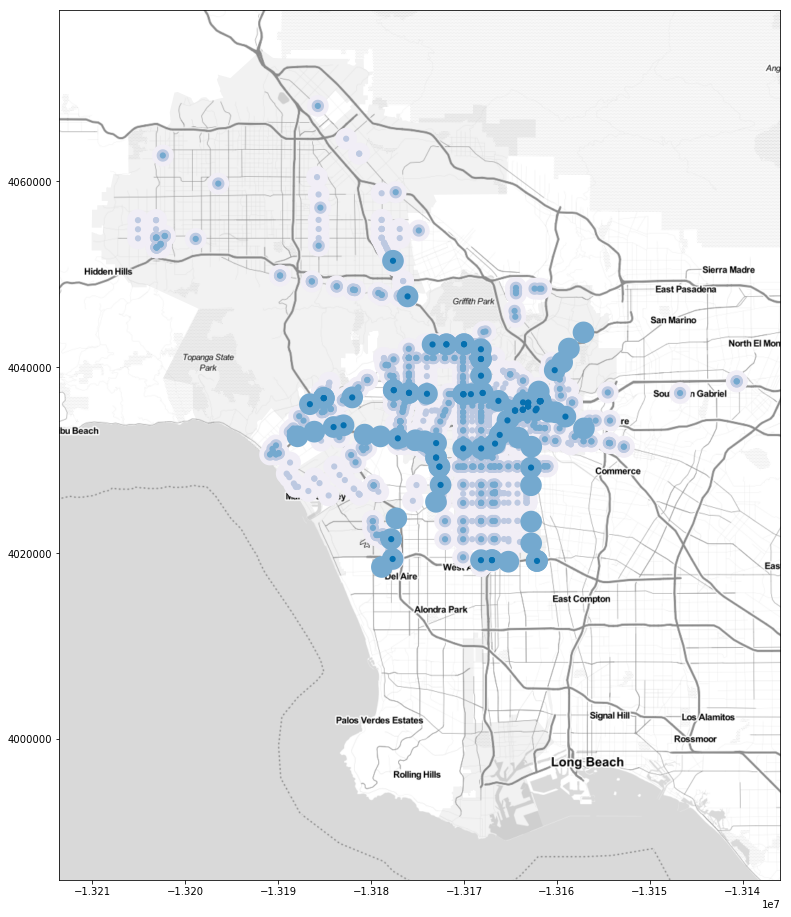

In [16]:
col_order = [
    "line_id_a", "line_id_b", "line_name_a", "line_name_b", "station_id", "station_name",
    "geometry", "tier_1", "tier_2", "tier_3", "tier_4",
    "mode_a", "mode_b", "agency_a", "agency_b", 
]

toc_tiers = pd.concat(
    [
        toc_bus_intersection_tiers,
        toc_metrolink_tiers,
        toc_metro_rail_tiers,
    ],
    axis=0,
    sort=False
).reindex(columns = col_order)


fig = plot_toc_tiers(toc_tiers)
fig.show()

In [17]:
toc_tiers.drop(columns = ['geometry', 'tier_2', 'tier_3', 'tier_4']
              ).set_geometry('tier_1').to_file(driver = 'GeoJSON', 
                                               filename = '../gis/intermediate/reconstructed_toc_tiers_1.geojson')

toc_tiers.drop(columns = ['geometry', 'tier_1', 'tier_3', 'tier_4']
              ).set_geometry('tier_2').to_file(driver = 'GeoJSON', 
                                               filename = '../gis/intermediate/reconstructed_toc_tiers_2.geojson')

toc_tiers.drop(columns = ['geometry', 'tier_1', 'tier_2', 'tier_4']
              ).set_geometry('tier_3').to_file(driver = 'GeoJSON', 
                                               filename = '../gis/intermediate/reconstructed_toc_tiers_3.geojson')

toc_tiers.drop(columns = ['geometry', 'tier_1', 'tier_2', 'tier_3']
              ).set_geometry('tier_4').to_file(driver = 'GeoJSON', 
                                               filename = '../gis/intermediate/reconstructed_toc_tiers_4.geojson')

toc_tiers.drop(columns = ['tier_1', 'tier_2', 'tier_3', 'tier_4']
              ).to_file(driver = 'GeoJSON', 
                        filename = '../gis/intermediate/reconstructed_toc_tiers_0.geojson')

for data in ['0', '1', '2', '3', '4']:
    dataset_name = f'gis/intermediate/reconstructed_toc_tiers_{data}.geojson'
    s3.upload_file(f'../{dataset_name}', bucket_name, dataset_name)

## Assigning entitlements to conditions

In [18]:
toc_eligible_parcels_with_entitlements = gpd.read_file(
    f"s3://{bucket_name}/gis/intermediate/toc_eligible_parcels_with_entitlements.geojson"
)

In [19]:
for col in ['line_id_a', 'line_id_b', 'line_name_a', 'line_name_b', 
            'station_id', 'station_name', 'mode_a', 'mode_b', 'agency_a', 'agency_b']:
    toc_tiers[col] = toc_tiers[col].fillna('')

In [20]:
parcels = toc_eligible_parcels_with_entitlements.to_crs(epsg=4326)

join = lambda gdf, tier: toc.join_with_toc_tiers(
    gdf,
    toc_bus_intersection_tiers,
    toc_metrolink_tiers,
    toc_metro_rail_tiers,
    tier,
)
        
tier_1 = join(parcels[(parcels.TOC_Tier == 1) & (parcels.num_TOC > 0)], 1)
tier_2 = join(parcels[(parcels.TOC_Tier == 2) & (parcels.num_TOC > 0)], 2)
tier_3 = join(parcels[(parcels.TOC_Tier == 3) & (parcels.num_TOC > 0)], 3)
tier_4 = join(parcels[(parcels.TOC_Tier == 4) & (parcels.num_TOC > 0)], 4)
"""
tier_3 = tier_3.assign(
    a_rapid = tier_3.apply(lambda x: toc.is_rapid_bus(x.agency_a, x.line_name_a), axis=1),
    b_rapid = tier_3.apply(lambda x: toc.is_rapid_bus(x.agency_b, x.line_name_b), axis=1),
)
tier_2 = tier_2.assign(
    a_rapid = tier_2.apply(lambda x: toc.is_rapid_bus(x.agency_a, x.line_name_a), axis=1),
    b_rapid = tier_2.apply(lambda x: toc.is_rapid_bus(x.agency_b, x.line_name_b), axis=1),
)
tier_1 = tier_1.assign(
    a_rapid = tier_1.apply(lambda x: toc.is_rapid_bus(x.agency_a, x.line_name_a), axis=1),
    b_rapid = tier_1.apply(lambda x: toc.is_rapid_bus(x.agency_b, x.line_name_b), axis=1),
)
"""

'\ntier_3 = tier_3.assign(\n    a_rapid = tier_3.apply(lambda x: toc.is_rapid_bus(x.agency_a, x.line_name_a), axis=1),\n    b_rapid = tier_3.apply(lambda x: toc.is_rapid_bus(x.agency_b, x.line_name_b), axis=1),\n)\ntier_2 = tier_2.assign(\n    a_rapid = tier_2.apply(lambda x: toc.is_rapid_bus(x.agency_a, x.line_name_a), axis=1),\n    b_rapid = tier_2.apply(lambda x: toc.is_rapid_bus(x.agency_b, x.line_name_b), axis=1),\n)\ntier_1 = tier_1.assign(\n    a_rapid = tier_1.apply(lambda x: toc.is_rapid_bus(x.agency_a, x.line_name_a), axis=1),\n    b_rapid = tier_1.apply(lambda x: toc.is_rapid_bus(x.agency_b, x.line_name_b), axis=1),\n)\n'

In [23]:
tier_1.columns

Index(['AIN', 'TOC_Tier', 'zone_class', 'num_TOC', 'num_nonTOC', 'geometry',
       'line_id_a', 'line_id_b', 'agency_a_left', 'line_name_a_left',
       'agency_b_x', 'line_name_b', 'tier_2_left', 'tier_3_left',
       'tier_4_left', 'mode_a_left', 'mode_b_x', 'station_name_x',
       'station_id', 'line_name_a_right', 'tier_2_right', 'tier_3_right',
       'tier_4_right', 'mode_a_right', 'agency_a_right', 'line_a_name',
       'line_a_id', 'station_name_y', 'line_b_id', 'line_b_name', 'agency_b_y',
       'tier_1', 'tier_2', 'tier_3', 'tier_4', 'mode_a', 'agency_a',
       'mode_b_y'],
      dtype='object')

In [26]:
tier_1[['line_id_a', 'line_id_b', 'tier_2', 'tier_2_left']]

,line_id_a,line_id_b,tier_2,tier_2_left
0,233-13108,152-13108,None,"POLYGON ((-118.44577 34.22156, -118.44579 34.2..."
1,233-13108,152-13108,None,"POLYGON ((-118.44577 34.22156, -118.44579 34.2..."
2,233-13108,164-13108,None,"POLYGON ((-118.44568 34.18668, -118.44569 34.1..."
3,233-13108,901-13108,None,"POLYGON ((-118.44271 34.18057, -118.44274 34.1..."
4,233-13108,164-13108,None,"POLYGON ((-118.44568 34.18668, -118.44569 34.1..."
...,...,...,...,...
154,757-13108,207-13108,None,"MULTIPOLYGON (((-118.31495 34.06808, -118.3150..."
155,704-13108,4-13108,None,"MULTIPOLYGON (((-118.23791 34.06063, -118.2379..."
156,757-13108,4-13108,None,"POLYGON ((-118.30322 34.09080, -118.30324 34.0..."
157,10-13108,757-13108,None,"POLYGON ((-118.30319 34.08354, -118.30321 34.0..."


In [ ]:
table = np.zeros(shape=(5, 4))
table[4,3] = tier_4.num_TOC.sum()
table[4,2] = tier_3.dropna(subset=["station"]).num_TOC.sum()
table[3,2] = tier_3.dropna(subset=["name"]).num_TOC.sum()
table[3,1] = tier_2.dropna(subset=["name"]).num_TOC.sum()
table[3,0] = tier_1.dropna(subset=["name"]).num_TOC.sum()
table[2,2] = tier_3[tier_3.a_rapid & tier_3.b_rapid].dropna(subset=["route_a"]).num_TOC.sum()
table[2,1] = tier_2[tier_2.a_rapid & tier_2.b_rapid].dropna(subset=["route_a"]).num_TOC.sum()
table[1,2] = tier_3[tier_3.a_rapid ^ tier_3.b_rapid].dropna(subset=["route_a"]).num_TOC.sum()
table[1,1] = tier_2[tier_2.a_rapid ^ tier_2.b_rapid].dropna(subset=["route_a"]).num_TOC.sum()
table[1,0] = tier_1[tier_1.a_rapid ^ tier_1.b_rapid].dropna(subset=["route_a"]).num_TOC.sum()
table[0,1] = tier_2[~tier_2.a_rapid & ~tier_2.b_rapid].dropna(subset=["route_a"]).num_TOC.sum()
table[0,0] = tier_1[~tier_1.a_rapid & ~tier_1.b_rapid].dropna(subset=["route_a"]).num_TOC.sum()


fig, ax = plt.subplots(figsize=(16,16))
pos = ax.imshow(table, cmap="magma")
ax.set_axis_off()
ax.text(-2.1, 0.0, "Two Regular Buses", fontsize=24)
ax.text(-2.1, 1.0, "Regular plus Rapid Bus", fontsize=24)
ax.text(-2.1, 2.0, "Two Rapid Buses", fontsize=24)
ax.text(-2.1, 3.0, "Metrolink Rail Stations", fontsize=24)
ax.text(-2.1, 4.0, "Metro Rail Stations", fontsize=24)
ax.text(-0.2, -0.6, "Tier 1", fontsize=24)
ax.text(0.8, -0.6, "Tier 2", fontsize=24)
ax.text(1.8, -0.6, "Tier 3", fontsize=24)
ax.text(2.8, -0.6, "Tier 4", fontsize=24)
cb = fig.colorbar(pos, ax=ax)
cb.ax.tick_params(labelsize=16)
ax.text(0.6, -1.0, "TOC Entitlements", fontsize=36)
plt.savefig("toc.png", bbox_inches='tight')

In [ ]:
def summarize(tier, header):
    display(Markdown(header))
    metro_rail_summary = (
        tier.groupby(["station"])
        .size()
        .sort_values(ascending=False)
        .to_frame("Entitlements")
    )
    if len(metro_rail_summary):
        display(Markdown("#### Metro Rail"))
        display(metro_rail_summary)
    metrolink_summary = (
        tier.groupby("name")
        .size()
        .sort_values(ascending=False)
        .to_frame("Entitlements")
    )
    metrolink_summary = metrolink_summary.reindex(
        index=metrolink_summary.index.rename("Station")
    )
    if len(metrolink_summary):
        display(Markdown("#### Metrolink"))
        display(metrolink_summary)
    
    a = tier.groupby("route_name_a").size().to_frame("Entitlements")
    b = tier.groupby("route_name_b").size().to_frame("Entitlements")
    bus_summary = (
        a.reindex(
            index=(a.index | b.index).rename("Bus Route")
        ).fillna(0).astype("int") + 
        b.reindex(
            index=(a.index | b.index).rename("Bus Route")
        ).fillna(0).astype("int")
    )
    if len(bus_summary):
        display(Markdown("#### Bus Lines"))
        display(bus_summary.sort_values("Entitlements", ascending=False).head(60))

In [ ]:
# TODO: Figure out a better deduplicating strategy.
summarize(tier_1.drop_duplicates(subset=["AIN"]), "## Tier 1 Statistics")
summarize(tier_2.drop_duplicates(subset=["AIN"]), "## Tier 2 Statistics")
summarize(tier_3.drop_duplicates(subset=["AIN"]), "## Tier 3 Statistics")
summarize(tier_4.drop_duplicates(subset=["AIN"]), "## Tier 4 Statistics")